In [1]:
%include "EnableIPythonDisplay.swift"
print(Python.version)
import TensorFlow

3.6.9 (default, Apr 18 2020, 01:56:04) 
[GCC 8.4.0]


In [2]:
let np = Python.import("numpy")
let plt = Python.import("matplotlib.pyplot")
//let pd = Python.import("pandas")
let cv2 = Python.import("cv2")
IPythonDisplay.shell.enable_matplotlib("inline")

('inline', 'module://ipykernel.pylab.backend_inline')


In [3]:
// Dummy data.
let x: Tensor<Float> = Tensor(randomNormal: [100, 4])
let y: Tensor<Int32> = Tensor(randomUniform: [100])
let hiddenSize: Int = 10

struct Model: Layer {
    var layer1 = Dense<Float>(inputSize: 4, outputSize: hiddenSize, activation: relu)
    var layer2 = Dense<Float>(inputSize: hiddenSize, outputSize: hiddenSize, activation: relu)
    var layer3 = Dense<Float>(inputSize: hiddenSize, outputSize: 3, activation: identity)
    
    @differentiable
    func callAsFunction(_ input: Tensor<Float>) -> Tensor<Float> {
        return input.sequenced(through: layer1, layer2, layer3)
    }
}

In [4]:
func quant_4<T>(_ x: Tensor<T>) -> Tensor<T> where T : TensorFlowFloatingPoint {
    let scale = 15 / abs(x).max()
    let x_q = round(scale * x)
    return x_q / scale
}

func quant_2<T>(_ x: Tensor<T>) -> Tensor<T> where T : TensorFlowFloatingPoint {
    let scale = 3 / abs(x).max()
    let x_q = round(scale * x)
    return x_q / scale
}

func quant_1<T>(_ x: Tensor<T>) -> Tensor<T> where T : TensorFlowFloatingPoint {
    let scale = abs(x).max()
    let x_q = round(scale * x)
    return x_q / scale
}

@derivative(of: quant_4)
func quant_4_Derivative<T>(_ x: Tensor<T>) -> (value: Tensor<T>, pullback: (Tensor<T>) -> Tensor<T>)
where T : TensorFlowFloatingPoint {
    let y = quant_4(x)
    return (value: y, pullback: { v in v})
}

@derivative(of: quant_2)
func quant_2_Derivative<T>(_ x: Tensor<T>) -> (value: Tensor<T>, pullback: (Tensor<T>) -> Tensor<T>)
where T : TensorFlowFloatingPoint {
    let y = quant_2(x)
    return (value: y, pullback: { v in v})
}

@derivative(of: quant_1)
func quant_1_Derivative<T>(_ x: Tensor<T>) -> (value: Tensor<T>, pullback: (Tensor<T>) -> Tensor<T>)
where T : TensorFlowFloatingPoint {
    let y = quant_1(x)
    return (value: y, pullback: { v in v})
}

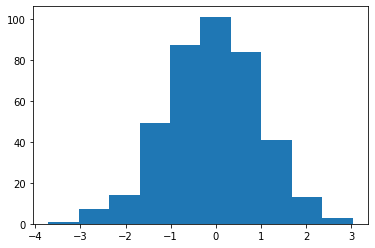

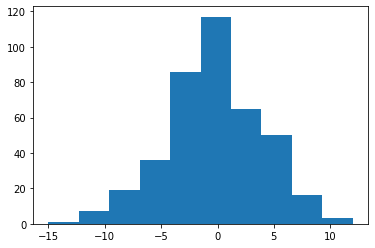

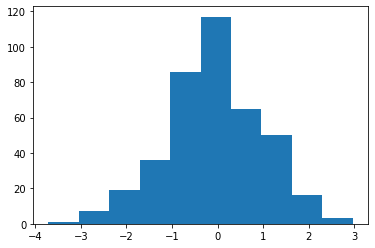

None


In [5]:
plt.hist(x.flattened().makeNumpyArray())
plt.show()
plt.hist(round((15 * x / abs(x).max()).flattened()).makeNumpyArray())
plt.show()
plt.hist(quant_4(x).flattened().makeNumpyArray())
plt.show()

In [35]:
struct Q4Model: Layer {
    var layer1 = Dense<Float>(inputSize: 4, outputSize: hiddenSize, activation: quant_4)
    var layer2 = Dense<Float>(inputSize: hiddenSize, outputSize: hiddenSize, activation: quant_4)
    var layer3 = Dense<Float>(inputSize: hiddenSize, outputSize: 3, activation: identity)
    
    @differentiable
    func callAsFunction(_ input: Tensor<Float>) -> Tensor<Float> {
        return input.sequenced(through: layer1, layer2, layer3)
    }
}

struct Q2Model: Layer {
    var layer1 = Dense<Float>(inputSize: 4, outputSize: hiddenSize, activation: quant_2)
    var layer2 = Dense<Float>(inputSize: hiddenSize, outputSize: hiddenSize, activation: quant_2)
    var layer3 = Dense<Float>(inputSize: hiddenSize, outputSize: 3, activation: identity)
    
    @differentiable
    func callAsFunction(_ input: Tensor<Float>) -> Tensor<Float> {
        return input.sequenced(through: layer1, layer2, layer3)
    }
}

struct Q1Model: Layer {
    var layer1 = Dense<Float>(inputSize: 4, outputSize: hiddenSize, activation: quant_1)
    var layer2 = Dense<Float>(inputSize: hiddenSize, outputSize: hiddenSize, activation: quant_1)
    var layer3 = Dense<Float>(inputSize: hiddenSize, outputSize: 3, activation: identity)
    
    @differentiable
    func callAsFunction(_ input: Tensor<Float>) -> Tensor<Float> {
        return input.sequenced(through: layer1, layer2, layer3)
    }
}

var all_vals = [[Float]]()

In [36]:
var classifier = Model()
let optimizer = SGD(for: classifier, learningRate: 0.2)
Context.local.learningPhase = .training
var vals = [Float]()
for _ in 0..<1000 {
    let (ŷ, backprop) = classifier.appliedForBackpropagation(to: x)
    let (loss, 𝛁ŷ) = valueWithGradient(at: ŷ) { ŷ in softmaxCrossEntropy(logits: ŷ, labels: y) }
    //print("Model output: \(ŷ), Loss: \(loss)")
    let val: Float = Float(loss.makeNumpyArray().flatten()[0])!
    vals.append(val)
    //print("\(String(format:"%.2e", val))", terminator: " ")
    let (𝛁model, _) = backprop(𝛁ŷ)
    optimizer.update(&classifier, along: 𝛁model)
}
all_vals.append(vals)

In [37]:
var classifier = Q4Model()
let optimizer = SGD(for: classifier, learningRate: 0.2)
Context.local.learningPhase = .training
var vals = [Float]()
for _ in 0..<1000 {
    let (ŷ, backprop) = classifier.appliedForBackpropagation(to: x)
    let (loss, 𝛁ŷ) = valueWithGradient(at: ŷ) { ŷ in softmaxCrossEntropy(logits: ŷ, labels: y) }
    //print("Model output: \(ŷ), Loss: \(loss)")
    let val: Float = Float(loss.makeNumpyArray().flatten()[0])!
    vals.append(val)
    //print("\(String(format:"%.2e", val))", terminator: " ")
    let (𝛁model, _) = backprop(𝛁ŷ)
    optimizer.update(&classifier, along: 𝛁model)
}
all_vals.append(vals)

In [38]:
var classifier = Q2Model()
let optimizer = SGD(for: classifier, learningRate: 0.2)
Context.local.learningPhase = .training
var vals = [Float]()
for _ in 0..<1000 {
    let (ŷ, backprop) = classifier.appliedForBackpropagation(to: x)
    let (loss, 𝛁ŷ) = valueWithGradient(at: ŷ) { ŷ in softmaxCrossEntropy(logits: ŷ, labels: y) }
    //print("Model output: \(ŷ), Loss: \(loss)")
    let val: Float = Float(loss.makeNumpyArray().flatten()[0])!
    vals.append(val)
    //print("\(String(format:"%.2e", val))", terminator: " ")
    let (𝛁model, _) = backprop(𝛁ŷ)
    optimizer.update(&classifier, along: 𝛁model)
}
all_vals.append(vals)

In [39]:
var classifier = Q1Model()
let optimizer = SGD(for: classifier, learningRate: 0.2)
Context.local.learningPhase = .training
var vals = [Float]()
for _ in 0..<1000 {
    let (ŷ, backprop) = classifier.appliedForBackpropagation(to: x)
    let (loss, 𝛁ŷ) = valueWithGradient(at: ŷ) { ŷ in softmaxCrossEntropy(logits: ŷ, labels: y) }
    //print("Model output: \(ŷ), Loss: \(loss)")
    let val: Float = Float(loss.makeNumpyArray().flatten()[0])!
    vals.append(val)
    //print("\(String(format:"%.2e", val))", terminator: " ")
    let (𝛁model, _) = backprop(𝛁ŷ)
    optimizer.update(&classifier, along: 𝛁model)
}
all_vals.append(vals)

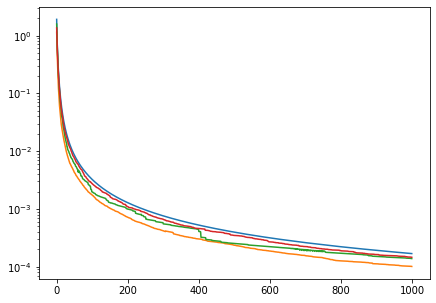

None


In [40]:
var fig = plt.figure(figsize: [7, 5])
plt.plot(all_vals[0])
plt.plot(all_vals[1])
plt.plot(all_vals[2])
plt.plot(all_vals[3])
plt.yscale("log")
plt.show() //fig.savefig("t.png")